In [1]:
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from helper_files.AutoEncoderHelper import scale,inverse_scale
from matplotlib import pyplot as plt
import json
import numpy as np
import pandas as pd
from Autoencoder.ComposedAutoencoder import ComposedAutoEncoder
from math import floor
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


**Check if GPU is available**

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**Create usable data from CSV file**


In [3]:
# Read csv file
FILE = 'data/weather_germany_ver2_0_16752_796037235.csv'
df = pd.read_csv(FILE, delimiter=';')

# Drop column SNOWDEPTH
df.drop('SNOWDEPTH', axis=1, inplace=True)

# Get groups of grid numbers
with open('data/grid_set_list.txt') as file:
    groups = json.load(file)

# Get separate DataFrame for each group in groups
data_for_each_group = [
    df[df['GRID_NO'].isin(group)].sort_values(by='GRID_NO', kind='mergesort') for group in groups
]

# Get all years of group 1  as a numpy array
data_for_each_group = [
    data.groupby('GRID_NO').head(data.index).to_numpy() for data in data_for_each_group[1:2]
]

**Create predefined variables**

In [4]:
# Lines per request
number_of_lines = len(groups[0])

# Structure of the autoencoder
layer_sizes = [
    11 * number_of_lines,
    int(11 * number_of_lines * 0.8),
    int(11 * number_of_lines * 0.2)
]

# Some variables for output progress
counter = 0
number_of_groups = len(data_for_each_group)

In [5]:
print(layer_sizes)

[55, 44, 11]


**Prepare Data**

In [6]:
data=data_for_each_group[0]
# Scale all values between 0 and 1
data_scaled = scale(data)

# Split data on in arrays for each grid number
data_split = np.array_split(data_scaled, number_of_lines)

# Merge arrays line by line
data_flatten = np.hstack(data_split)

half=floor(len(data_flatten)/2)

halfData=data_flatten[:half]
restOfData=data_flatten[half:]


X,Y=train_test_split(halfData,test_size=0.2, shuffle=False)





**Train Model**

In [7]:
# Name pretrained model like smallest grid number of the group
smallestGridNumber=int(data[0, 0])
file_name = '{}.h5'.format(smallestGridNumber)

checkpointPath='models/trained_modelsShit/{}'.format(file_name)

# Create autoencoder object
composedAutoencoder = ComposedAutoEncoder(layer_sizes)

composedAutoencoder.train(train_data=X,checkpoint_path=checkpointPath)
print(smallestGridNumber)



Train on 99 samples, validate on 99 samples
Epoch 1/10
99/99 [==============================] - 1s 8ms/sample - loss: 0.1125 - val_loss: 0.0995
Epoch 2/10
99/99 [==============================] - 0s 771us/sample - loss: 0.0926 - val_loss: 0.0816
Epoch 3/10
99/99 [==============================] - 0s 732us/sample - loss: 0.0758 - val_loss: 0.0665
Epoch 4/10
99/99 [==============================] - 0s 710us/sample - loss: 0.0616 - val_loss: 0.0538
Epoch 5/10
99/99 [==============================] - 0s 727us/sample - loss: 0.0497 - val_loss: 0.0432
Epoch 6/10
99/99 [==============================] - 0s 721us/sample - loss: 0.0397 - val_loss: 0.0344
Epoch 7/10
99/99 [==============================] - 0s 700us/sample - loss: 0.0316 - val_loss: 0.0272
Epoch 8/10
99/99 [==============================] - 0s 702us/sample - loss: 0.0249 - val_loss: 0.0214
Epoch 9/10
99/99 [==============================] - 0s 700us/sample - loss: 0.0197 - val_loss: 0.0169
Epoch 10/10
99/99 [=====================

**Plot Model Loss**


In [14]:
for (history,modelName) in zip(historyOfModels,filenames):
    #loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss of model '+modelName)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

NameError: name 'historyOfModels' is not defined

**Predict Test Data**

In [8]:
predictedData= composedAutoencoder.autoencoder_predict(Y)

In [9]:
def createListWithXEntires(myList,numberOfEntires):
    
    predictedDataInOwnList=[]

    for prediction in myList:
    
        listOfSingleGroupNr=[]
    
         
        for predictedValue in prediction:
        
            listOfSingleGroupNr.append(predictedValue)
        
            if len(listOfSingleGroupNr)==numberOfEntires:
            
                predictedDataInOwnList.append(listOfSingleGroupNr)
                listOfSingleGroupNr=[]

                
                
    return np.array(predictedDataInOwnList)
    

In [10]:
yAsNormalList=createListWithXEntires(np.array(Y).tolist(),11)
predictionAsNormalList=createListWithXEntires(predictedData,11)

**Regresion Chart of the prediction**  
Taken from [here](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_04_3_regression.ipynb)

In [11]:
# Regression chart.
def chart_regression(pred, y,feature,nameOfModel,sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.plot(t['y'].tolist(), label='expected',alpha=0.5) 
    plt.ylabel('output')
    plt.title(feature+" of model: "+nameOfModel)
    plt.legend()
    #plt.savefig(feature)
    plt.show()

In [12]:
def useChartRegressionOnGoldAndPredicted(goldData,myPredictedData,numberOfRowElementsInRealData):
    yAsNormalList=createListWithXEntires(np.array(goldData).tolist(),numberOfRowElementsInRealData)
    predictionAsNormalList=createListWithXEntires(myPredictedData,numberOfRowElementsInRealData)
    
    datasetColumns=["GRID_NO","LATITUDE","LONGITUDE","ALTITUDE","DAY","TEMPERATURE_MAX","TEMPERATURE_MIN","TEMPERATURE_AVG","WINDSPEED","VAPOURPRESSURE","RADIATION"]
    dataFrameOfTest=pd.DataFrame(inverse_scale(yAsNormalList),columns=datasetColumns)
    dataFrameOfPrediction=pd.DataFrame(inverse_scale(predictionAsNormalList),columns=datasetColumns)
    
    for predictionColumns,testDataColumns in zip(dataFrameOfPrediction.columns,dataFrameOfTest.columns):
        chart_regression(dataFrameOfPrediction[predictionColumns].to_numpy().flatten(),dataFrameOfTest[testDataColumns].to_numpy(),predictionColumns,file_name)

Prediction of Y


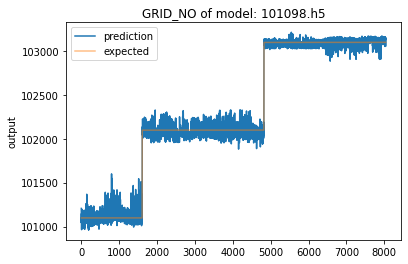

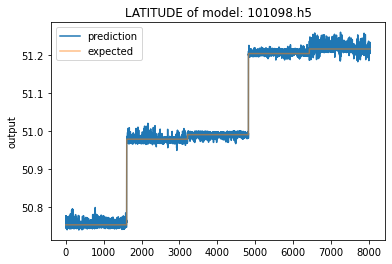

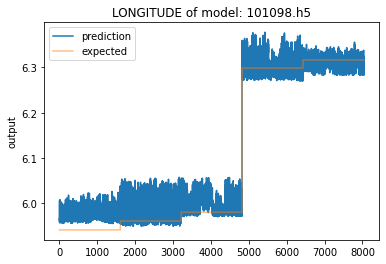

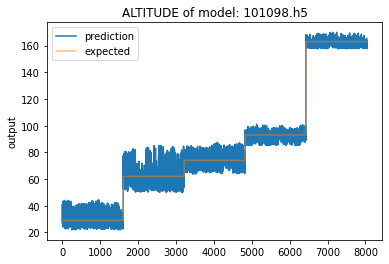

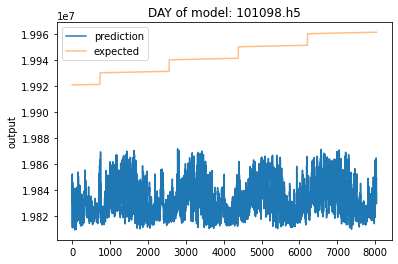

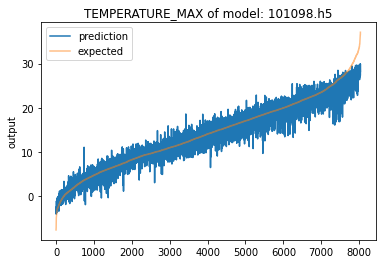

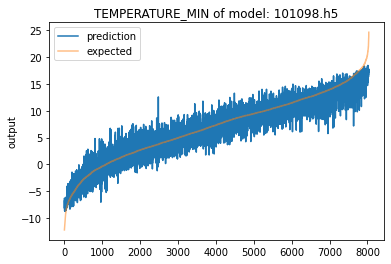

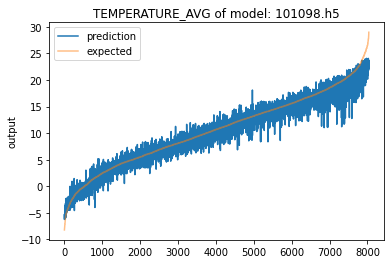

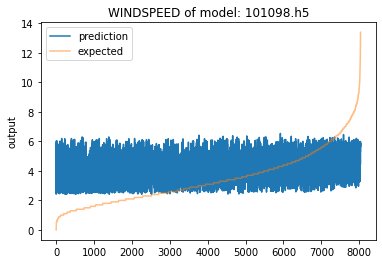

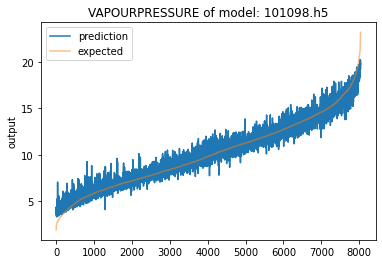

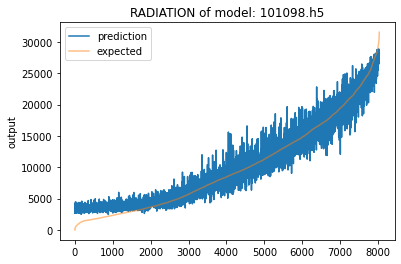

In [13]:
print("Prediction of Y")
useChartRegressionOnGoldAndPredicted(Y,predictedData,11)

**Training on the rest of the dataset to test Dynamic compression**

In [14]:
def get_trained_model(inc_data):
    return 'models/trained_modelsShit/' + str(int(inc_data[0][0])) + '.h5'


def get_trained_model_by_gridno(smallest_grid_no):
    return 'models/trained_modelsShit/' + str(int(smallest_grid_no)) + '.h5'


def get_reference_model(inc_data):
    return 'models/reference_modelsShit/' + str(int(inc_data[0][0])) + '.h5'


def get_reference_model_by_gridno(smallest_grid_no):
    return 'models/reference_modelsShit/' + str(int(smallest_grid_no)) + '.h5'

In [15]:
number_of_neurons_to_decrease=2
factor = 3



for elem in restOfData[:10]:
       
    composedAutoencoder.train(np.array([elem]),checkpointPath)
    
    if composedAutoencoder.model_with_better_compression_in_build():
        if composedAutoencoder.get_Deviation_From_Original_Data_AE_better_compression()<=0.20:
            composedAutoencoder.set_model_with_better_compression_as_new_autoencoder(get_trained_model_by_gridno(smallestGridNumber))
    
    print("Deviation from training data: ",composedAutoencoder.get_Deviation_From_Original_Data_Autoencoder()*100,"%")
    
    if composedAutoencoder.get_Deviation_From_Original_Data_Autoencoder()<=0.20 and not composedAutoencoder.model_with_better_compression_in_build() and composedAutoencoder.better_compression_possible(number_of_neurons_to_decrease):
        composedAutoencoder.create_autoencoder_better_compression(number_of_neurons_to_decrease)
        composedAutoencoder.save_autoencoder_with_better_compression(autoencoder_path=get_trained_model_by_gridno(smallestGridNumber))
    
    if composedAutoencoder.better_than_reference(np.array([elem]), factor):
        
        # Load trained model which is better than the reference model
        composedAutoencoder.load_models(reference_path=get_trained_model_by_gridno(smallestGridNumber))

        # Save a copy of the reference model
        composedAutoencoder.save_models(reference_path=get_reference_model_by_gridno(smallestGridNumber))
        
        if composedAutoencoder.model_with_better_compression_in_build():
            composedAutoencoder.update_weights_of_autoencoder_with_better_compression()
    
    

Train on 1 samples, validate on 1 samples
Epoch 1/10
1/1 [==============================] - 0s 42ms/sample - loss: 9.0019e-04 - val_loss: 8.0500e-04
Epoch 2/10
1/1 [==============================] - 0s 50ms/sample - loss: 8.0500e-04 - val_loss: 6.7782e-04
Epoch 3/10
1/1 [==============================] - 0s 41ms/sample - loss: 6.7782e-04 - val_loss: 5.5979e-04
Epoch 4/10
1/1 [==============================] - 0s 36ms/sample - loss: 5.5979e-04 - val_loss: 4.7660e-04
Epoch 5/10
1/1 [==============================] - 0s 42ms/sample - loss: 4.7660e-04 - val_loss: 4.3563e-04
Epoch 6/10
1/1 [==============================] - 0s 37ms/sample - loss: 4.3563e-04 - val_loss: 4.2598e-04
Epoch 7/10
1/1 [==============================] - 0s 12ms/sample - loss: 4.2598e-04 - val_loss: 4.3265e-04
Epoch 8/10
1/1 [==============================] - 0s 11ms/sample - loss: 4.3265e-04 - val_loss: 4.4240e-04
Epoch 9/10
1/1 [==============================] - 0s 12ms/sample - loss: 4.4240e-04 - val_loss: 4.4504